<a href="https://colab.research.google.com/github/MateoPeri/steel-scrap-predictor/blob/simple/Steel%20Scrap%20Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
import pandas as pd
import numpy as np
import glob, os

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split

# from fbprophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import altair as alt
plt.style.use('seaborn-poster')

# Data preparation

In [2]:
!rm -rf '/content/data'
!mkdir data
PATH = '/content/data/'
!wget -P {PATH} https://raw.githubusercontent.com/MateoPeri/steel-scrap-predictor/master/data/raw.zip
!unzip {PATH}raw.zip -d {PATH}

--2020-06-20 16:31:30--  https://raw.githubusercontent.com/MateoPeri/steel-scrap-predictor/master/data/raw.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2552121 (2.4M) [application/zip]
Saving to: ‘/content/data/raw.zip’

raw.zip             100%[===================>]   2.43M  10.0MB/s    in 0.2s    

2020-06-20 16:31:31 (10.0 MB/s) - ‘/content/data/raw.zip’ saved [2552121/2552121]

Archive:  /content/data/raw.zip
   creating: /content/data/raw/
  inflating: /content/data/raw/CSF EOI.xlsx  
  inflating: /content/data/raw/CSF TV.xlsx  
  inflating: /content/data/raw/HC Closing Prices.xlsx  
  inflating: /content/data/raw/HC Final Settlement prices.xlsx  
  inflating: /content/data/raw/HU Closing Prices.xlsx  
  inflating: /content/data/raw/HU Final Settlemen

## Load dataset

In [3]:
def st_to_mt(st):
  return st/1.10231131

Load Price data

In [4]:
# por ahora solo SC y SR
ignore = ['SR', 'HU', 'HC', 'AM', 'UP']

In [5]:
p = PATH+'raw/*Closing Prices.xlsx'
excels = glob.glob(p)

frames = {}

for xcel in excels:
  d = pd.read_excel(xcel, parse_dates=True, decimal=',', thousands='.')
  # le añadimos un nombre para saber qué metal es
  name = os.path.basename(xcel)[:2]
  if name in ignore: continue
  if name == 'HU':
    # Seleccionar todas las columnas menos USD/st
    cols = [c for c in d.columns if c != 'USD/st (Short Ton)']
    # y aplicarles la funcion st_to_mt para pasar a toneladas métricas
    d[cols] = d[cols].apply(st_to_mt, axis=1)
    # Cambiamos el nombre a la columna
    d.rename({'USD/st (Short Ton)': 'USD/mt'}, axis=1, inplace=True)
  
  d.columns = ['Date'] + [name+'_'+c for c in d.columns if c != 'USD/mt']
  
  frames[name] = d

dfs = [d.drop_duplicates().set_index(['Date']) for d in frames.values()]
price_df = pd.concat(dfs, axis=1)

price_df.head()

,SC_M1,SC_M2,SC_M3,SC_M4,SC_M5,SC_M6,SC_M7,SC_M8,SC_M9,SC_M10,SC_M11,SC_M12,SC_M13,SC_M14,SC_M15
Date,,,,,,,,,,,,,,,
2015-11-23,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0
2015-11-24,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0
2015-11-25,195.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0
2015-11-26,192.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0
2015-11-27,192.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0


In [6]:
all_df = price_df

In [7]:
# Contamos los valores nulos del dataset -> 0
all_df.isnull().sum().sum()

0

## Análisis

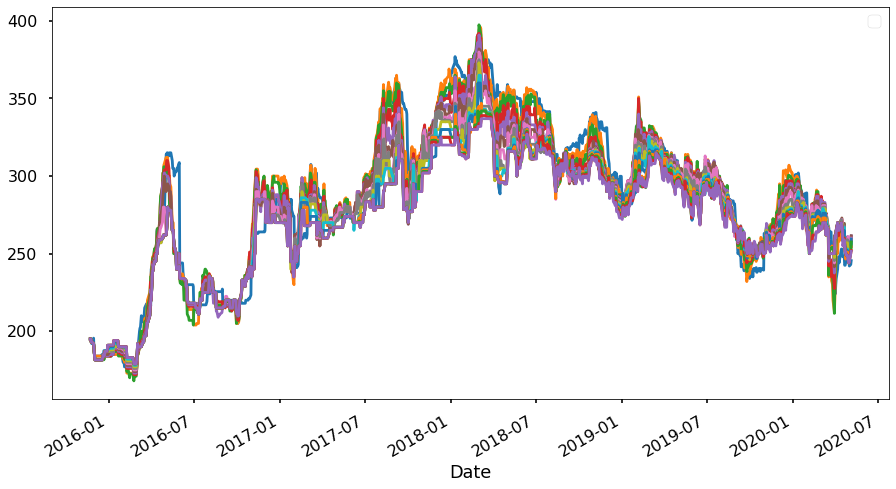

In [8]:
fig, ax = subplots()
price_df.plot(figsize=(15,8), ax=ax)
ax.legend([]);

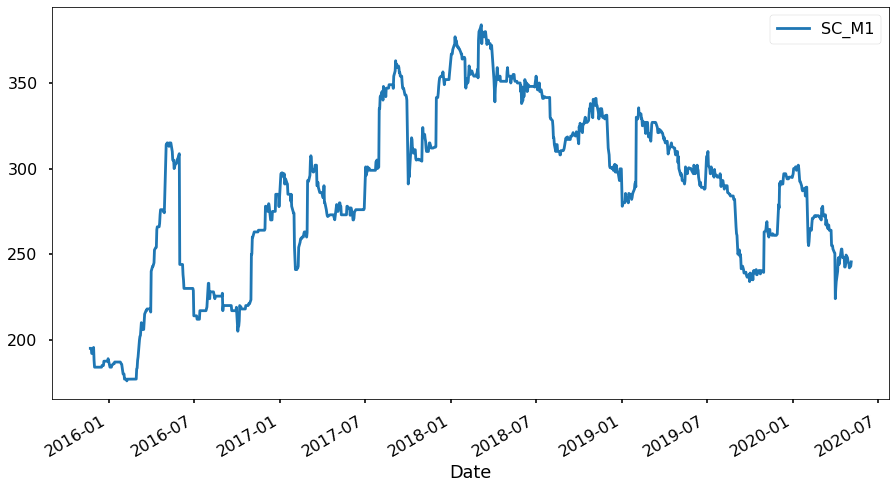

In [9]:
price_df[['SC_M1']].plot(figsize=(15,8))

# Model

In [10]:
to_predict = 'SC_M1'
data = all_df.reset_index().copy()

In [17]:
# Esto es para los modelos de series temporales
def add_caps(d1, d2=None, c='y'):
  if d2 is None:
    d2 = d1
  d2['cap'] = d1[c].max()
  d2['floor'] = d1[c].min()
  return d2

Hacemos una columna para poder hacer la predicción

In [12]:
from collections import defaultdict

def simplify_df(dff):
  dff = dff.copy()
  
  print(dff.columns)
  exclude = ['Date', 'TV', 'EOI']
  cols = [c for c in dff.columns if all([x not in c for x in exclude])]
  firsts = [c for c in cols if '1' in c and len(c) <= 5]
  others = [c for c in cols if c not in firsts]

  d = defaultdict(list)
  for o in others:
    k = [f for f in firsts if f[:2] == o[:2]][0]
    d[k].append(o)
  d = dict(d)
  
  new_df = dff.copy()
  count = 0
  for r in dff.itertuples():
    for k, vs in d.items():
      for v in vs:
        next_row = r.Date + pd.DateOffset(months=int(v[4:])-1)
        new_val = new_df.loc[new_df.Date == r.Date, v].values[0]
        #print(v, next_row, r.Date, int(v[4:]))

        if next_row not in pd.to_datetime(new_df.Date.values):
          #print(next_row, 'no estaba')
          new_df = new_df.append({'Date': next_row}, ignore_index=True)
          
        # si no es nan, hacer media. o que tenga mas importancia el valor rea
        vals = new_df.loc[new_df.Date == next_row, k]
        #print(vals)
        #if any(m == np.NaN for m in vals) or len(vals) == 0:
        if new_df.loc[new_df.Date == next_row, k].isnull().any():
          #print(next_row, '-> set directo:', new_val)
          new_df.loc[new_df.Date == next_row, k] = new_val
        else:
          l = [new_df.loc[new_df.Date == next_row, k], new_val]
          new_df.loc[new_df.Date == next_row, k] = sum(l)/len(l)

  new_df.drop(others, axis=1, inplace=True)
  new_df.sort_values(by='Date', inplace=True)
  return new_df.drop_duplicates()

In [102]:
simp_df = simplify_df(data)
simp_df.head()

Index(['Date', 'SC_M1', 'SC_M2', 'SC_M3', 'SC_M4', 'SC_M5', 'SC_M6', 'SC_M7',
       'SC_M8', 'SC_M9', 'SC_M10', 'SC_M11', 'SC_M12', 'SC_M13', 'SC_M14',
       'SC_M15'],
      dtype='object')


,Date,SC_M1
0,2015-11-23,195.0
1,2015-11-24,195.0
2,2015-11-25,195.0
3,2015-11-26,192.0
4,2015-11-27,192.0


In [103]:
print(simp_df.shape)
simp_df.isnull().sum()

(2033, 2)


Date     0
SC_M1    0
dtype: int64

## Análisis

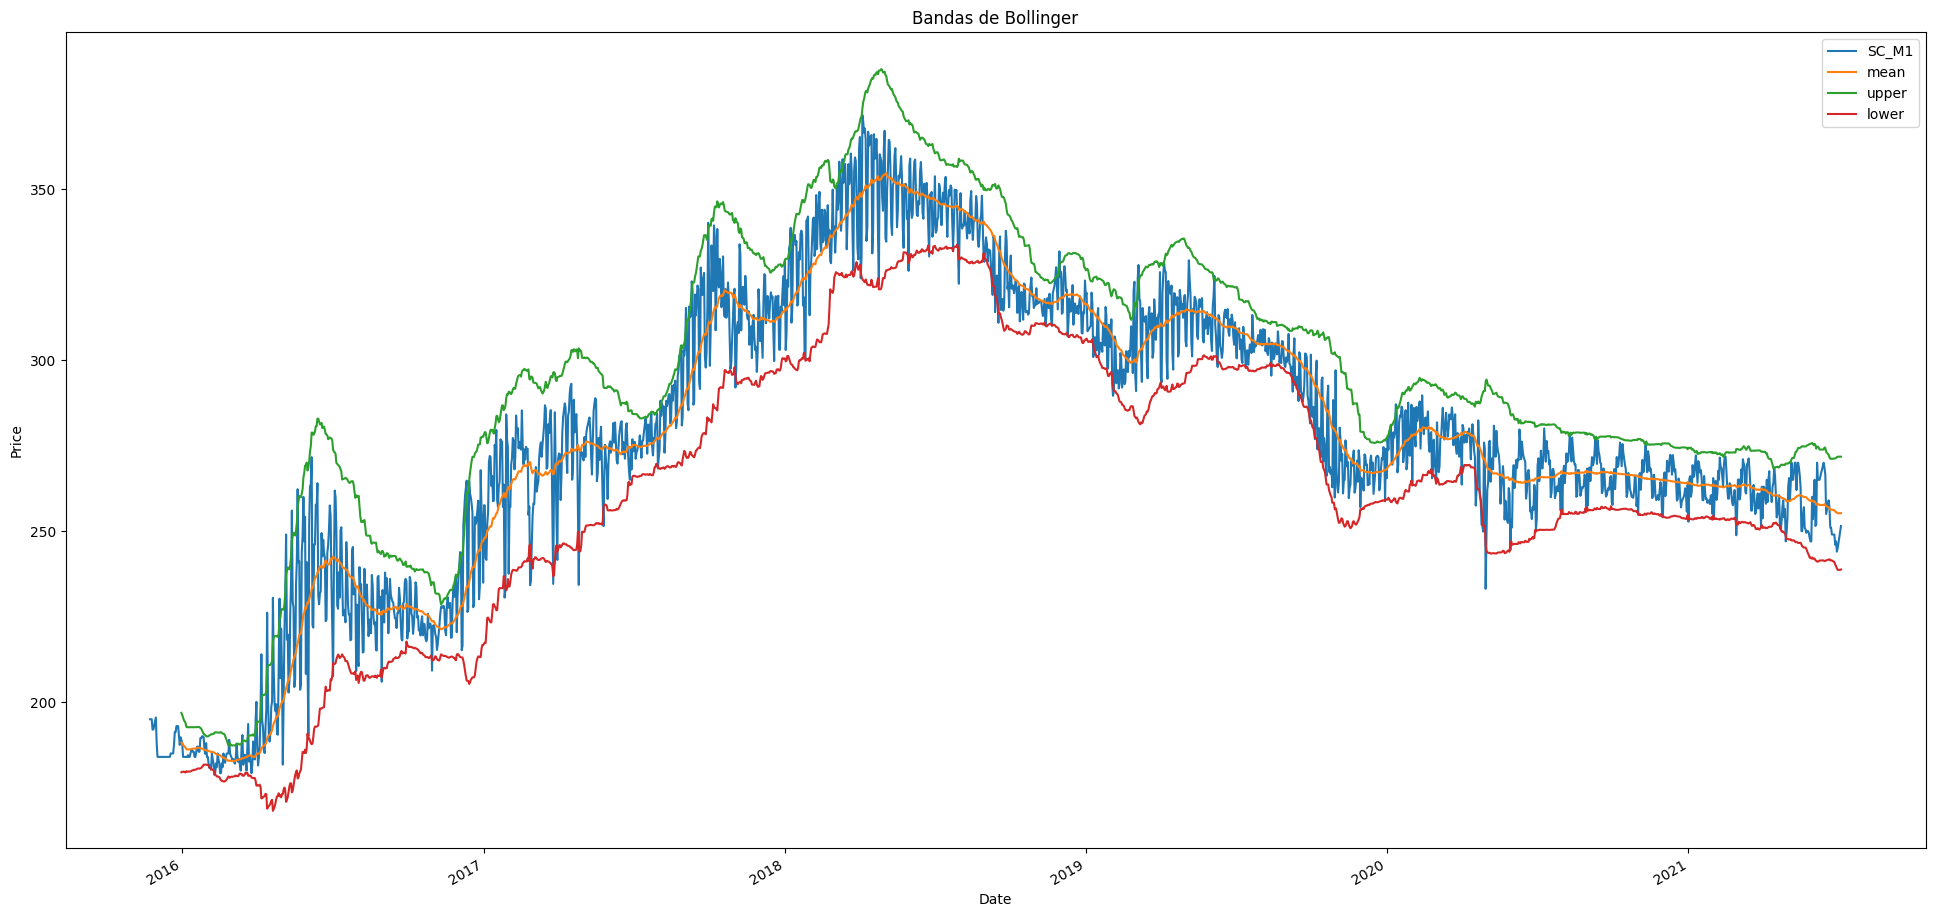

In [128]:
simp_df['mean'] = simp_df['SC_M1'].rolling(window=30).mean()

simp_df['std'] = simp_df['SC_M1'].rolling(window=30).std() 

simp_df['upper'] = simp_df['mean'] + (simp_df['std'] * 2)
simp_df['lower'] = simp_df['mean'] - (simp_df['std'] * 2)

simp_df[['Date', 'SC_M1', 'mean', 'upper', 'lower']].plot('Date', figsize=(24,12))
plt.title('Bandas de Bollinger')
plt.ylabel('Price')
plt.show();

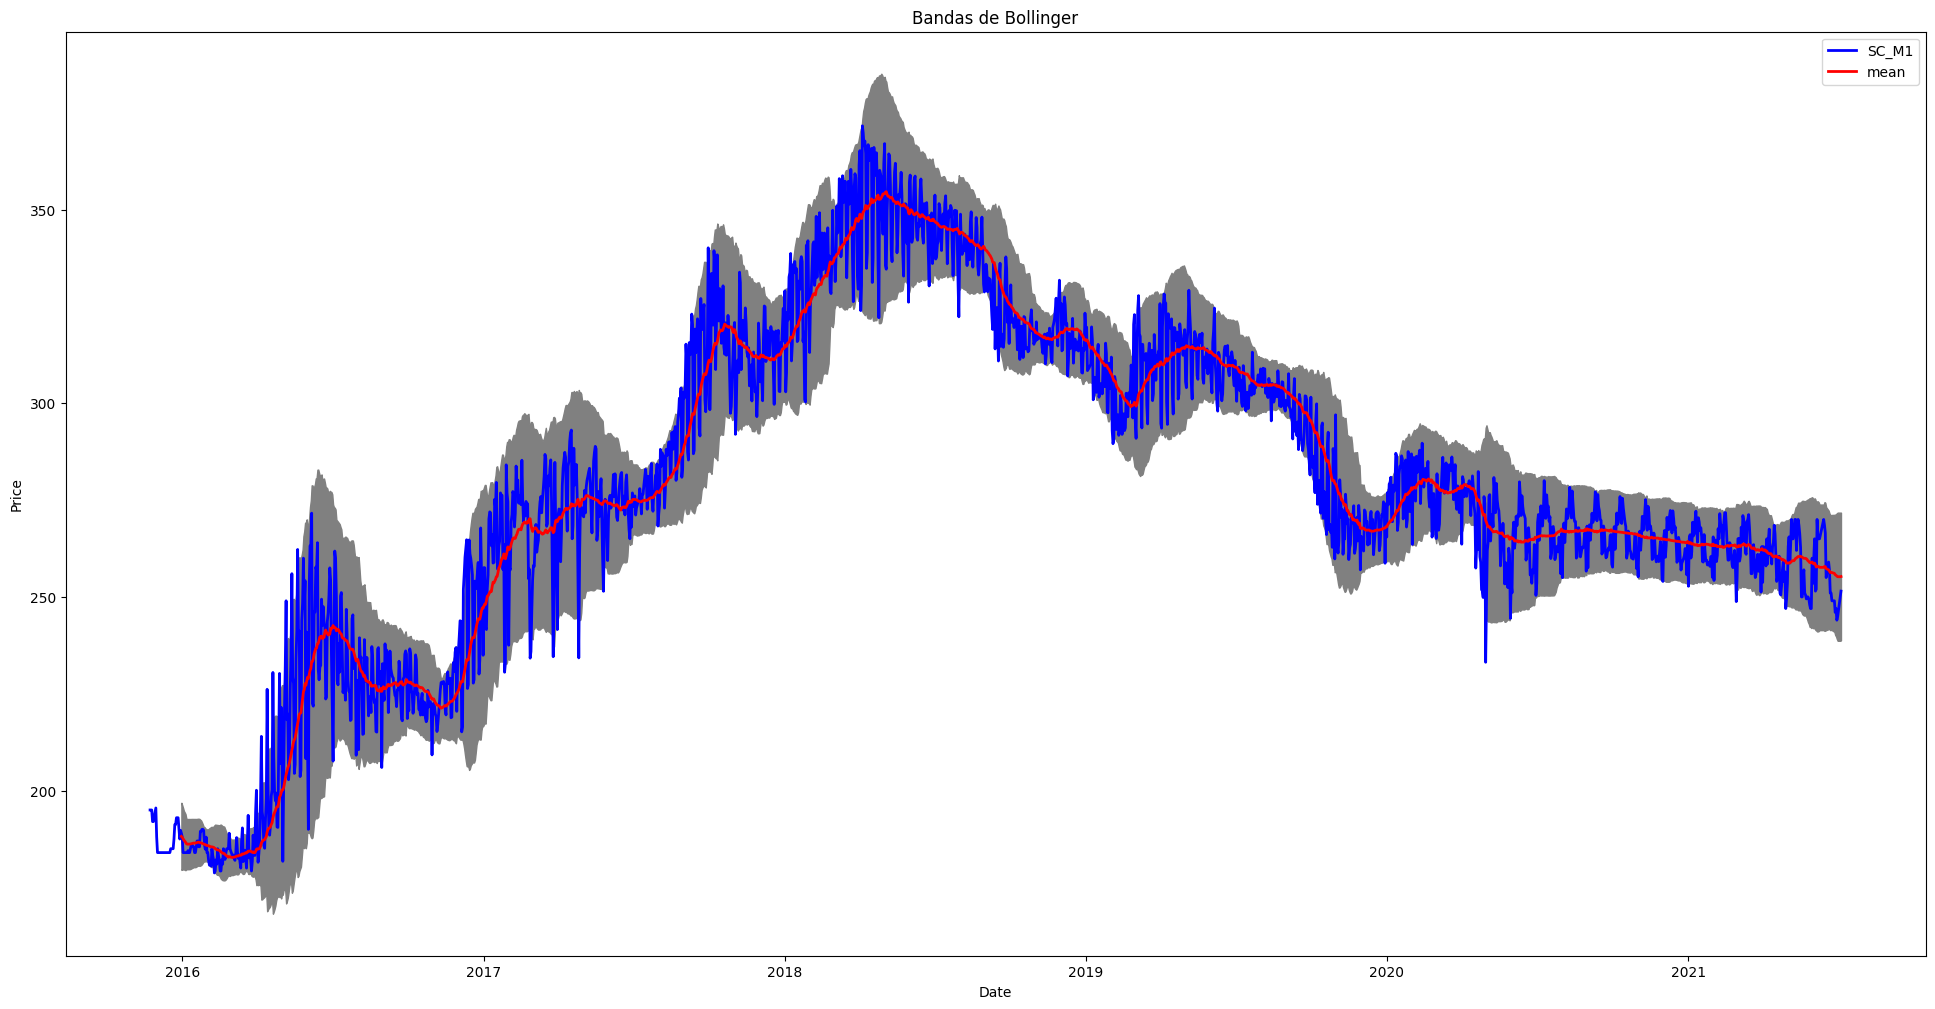

In [129]:
fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot()

x_axis = simp_df['Date'].values

ax.fill_between(x_axis, simp_df['upper'], simp_df['lower'], color='grey')

ax.plot(x_axis, simp_df['SC_M1'], color='b', lw=2)
ax.plot(x_axis, simp_df['mean'], color='r', lw=2)

ax.set_title('Bandas de Bollinger')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend(['SC_M1', 'mean'])
plt.show()

Separamos el dataset en X e y. Para hallar X, usamos el número de días que han pasado. y es el valor a predecir (SC_M1).

In [15]:
def get_features(dff):
  dff = dff.copy()

  others = [c for c in dff.columns if c not in ['Date', to_predict]]
  dff.rename({'Date': 'ds', to_predict: 'y'}, axis=1, inplace=True)
  dff.set_index(dff.ds, inplace=True)

  dff = add_caps(dff)
  dff['day'] = (dff.index - dff.index[0]).days
  X = dff[['day']]
  y = dff[['y']]
  
  return X, y

Hacemos train/test split

In [18]:
X, y = get_features(simp_df)
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Regresión Lineal

In [22]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
l_preds = linear_model.predict(X_test)

In [33]:
print ('W: ', linear_model.coef_)
print ('B: ', linear_model.intercept_)

W:  [[0.02282921]]
B:  [253.76051353]


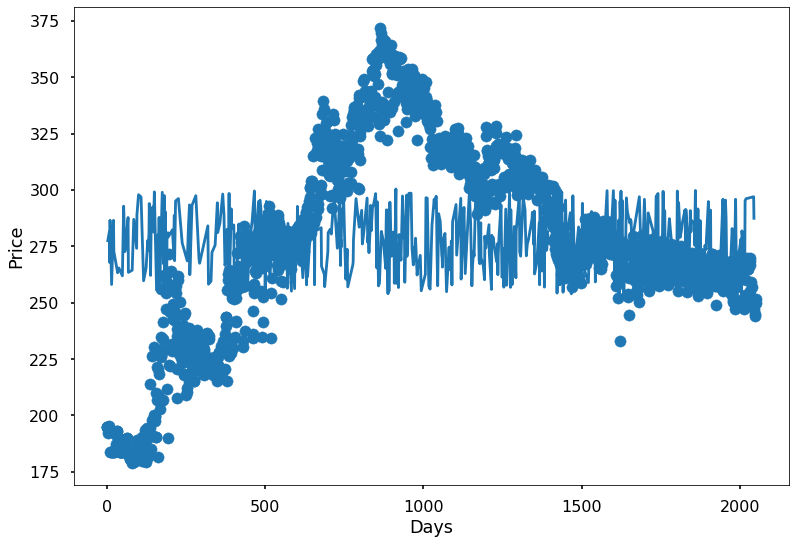

In [67]:
scatter(X_train, y_train)
plot(np.sort(X_test, axis=0), l_preds)
xlabel("Days")
ylabel("Price")
plt.show()

In [77]:
print("Mean absolute error: %.2f" % np.mean(np.absolute(l_preds - y_test)))
print("Residual sum of squares (MSE): %.2f" % np.mean((l_preds - y_test) ** 2))
print('Accuracy: {:.2f}%'.format(r2_score(l_preds, y_test)*100))

Mean absolute error: 35.58
Residual sum of squares (MSE): 1733.65
Accuracy: -908.99%


## Regresión Polinómica

Hacemos una regresión lineal, pero transformando antes los datos

In [72]:
deg = 5
poly = PolynomialFeatures(degree=deg)
X_train_poly = poly.fit_transform(X_train)

In [73]:
poly_model = LinearRegression()
train_y_ = poly_model.fit(X_train_poly, y_train)
print ('W: ', poly_model.coef_)
print ('B: ', poly_model.intercept_)

W:  [[ 0.00000000e+00 -1.14909423e-01  1.10999500e-03 -1.41481444e-06
   6.57950271e-10 -1.04777298e-13]]
B:  [195.73104677]


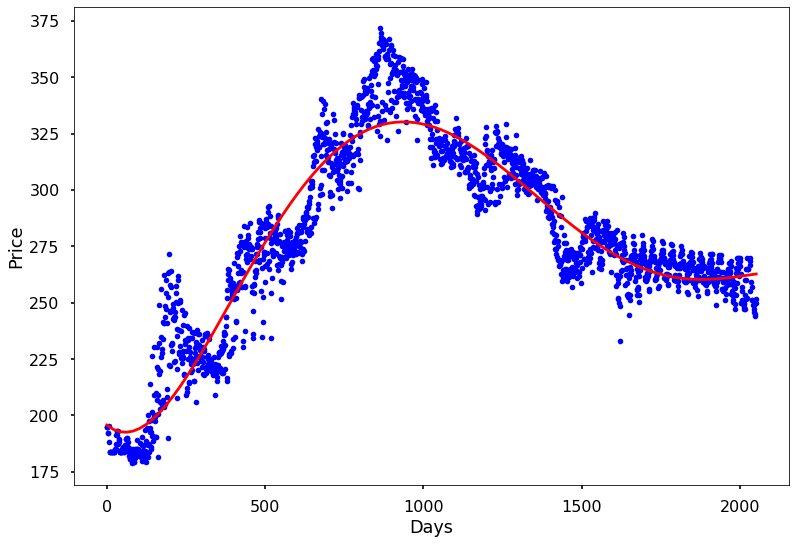

In [74]:
X_plot = np.linspace(min(X_train.day), max(X_train.day), 100).reshape(-1,1)
X_plot_poly = poly.fit_transform(X_plot)
plt.plot(X, y, "b.")
plot(X_plot_poly[:, 1], poly_model.predict(X_plot_poly), '-r')
xlabel("Days")
ylabel("Price")

plt.show()

In [80]:
test_x_poly = poly.fit_transform(X_test)
p_preds = poly_model.predict(test_x_poly)

print("Mean absolute error: %.2f" % np.mean(np.absolute(p_preds - y_test)))
print("Residual sum of squares (MSE): %.2f" % np.mean((p_preds - y_test) ** 2))
print('Accuracy: {:.2f}%'.format(r2_score(p_preds, y_test)*100))

Mean absolute error: 11.01
Residual sum of squares (MSE): 204.21
Accuracy: 87.16%


# Predict Future [EN PROCESO]

In [ ]:
# 3 more months from end of data
future = model.make_future_dataframe(periods=90, freq='d', include_history=False)
future = df_pred.append(future)
future = add_caps(df_pred, future)

In [ ]:
future.tail()

,ds,y,SR_M1,cap,floor
85,2020-07-25,NaN,NaN,369.78125,230.5
86,2020-07-26,NaN,NaN,369.78125,230.5
87,2020-07-27,NaN,NaN,369.78125,230.5
88,2020-07-28,NaN,NaN,369.78125,230.5
89,2020-07-29,NaN,NaN,369.78125,230.5


In [ ]:
future.set_index(['ds'], inplace=True)

In [ ]:
list(future.groupby([future.index.month]))[0]

(1,                      y       SR_M1        cap  floor
 ds                                                  
 2017-01-04  297.000000  442.000000  369.78125  230.5
 2017-01-05  297.500000  435.500000  369.78125  230.5
 2017-01-06  297.500000  435.000000  369.78125  230.5
 2017-01-09  295.000000  435.000000  369.78125  230.5
 2017-01-10  297.000000  435.000000  369.78125  230.5
 ...                ...         ...        ...    ...
 2020-01-27  274.109375  433.015625  369.78125  230.5
 2020-01-28  274.046875  436.048828  369.78125  230.5
 2020-01-29  271.929688  430.031250  369.78125  230.5
 2020-01-30  280.224609  440.863281  369.78125  230.5
 2020-01-31  272.292500  436.628750  369.78125  230.5
 
 [113 rows x 4 columns])

In [ ]:
# impute data
future[['SR_M1']] = future[['SR_M1']].fillna(future[['SR_M1']].mean())

In [ ]:
# Iterate through dates in batches of 30 days (1 month aprox) --> maybe 30.25??
# Substract amount of months since start
# assign corresponding data to batch rows

def fill_future(d, end):
  d = d.copy()
  d2 = d.loc[d.index > end].copy()
  last = d.loc[end]
  for n, m in list(d2.groupby([d2.index.month])):
    print('Month', n)
    diff = abs(n - end.month)
    print('Diff', diff)
    if diff == 0:
      m = last
    elif diff <= 15:
      m = d.loc[end, 'M'+str(diff)]
    else:
      raise ValueError('Trying to predict more than 15 months!')
      return
    
    print(d2.loc[d2.index.month == n, :].head())
    d2.loc[d2.index.month == n, :] = m[d2.columns].values
    print(d2.loc[d2.index.month == n].head())
    
    break
  d.loc[d.index > end] = d2
  return d

full_future = fill_future(future, df_pred.ds.iloc[-1])

full_future.tail(91).head(32)

,y,SR_M1,cap,floor
ds,,,,
2018-10-02,337.923828,533.191406,369.731445,230.0
2018-10-03,333.894531,533.256836,369.731445,230.0
2018-10-04,328.011719,530.001953,369.731445,230.0
2018-10-05,332.036133,532.421875,369.731445,230.0
2018-10-06,332.148926,533.074219,369.731445,230.0
2018-10-07,331.880859,533.636719,369.731445,230.0
2018-10-08,337.389648,539.023438,369.731445,230.0
2018-10-09,322.576172,526.527344,369.731445,230.0
2018-10-10,317.880859,513.773438,369.731445,230.0


In [ ]:
future = future.dropna()

In [ ]:
future.reset_index(inplace=True, drop=False)

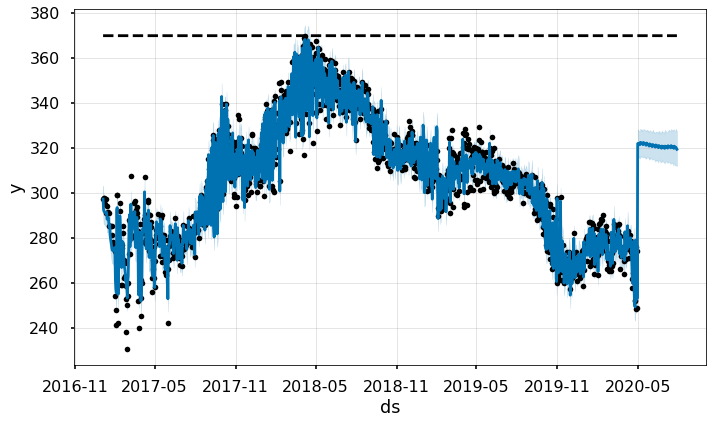

In [ ]:
future_forecast = model.predict(future)
fig = model.plot(future_forecast)

In [ ]:
future_forecast['fact'] = future['y'].reset_index(drop=True) # habría que tener un dataframe con datos de validación
print('Accuracy: {:.2f}%'.format(r2_score(future_forecast.fact, future_forecast.yhat)*100))